# Notebook: BERTopic to analyse the Topics

## 1. Load Packages

In [1]:
from plots import plot_topic_subplots, plot_timeseries_subplots, plot_timeseries_sentiment_subplots
from gensim.models.ldamodel import LdaModel
from bertopic import BERTopic
from gensim import corpora
import pandas as pd
import numpy as np
import random
import torch
import math
import re
import os

## 2. Constants / Setup

In [2]:
N_TOPICS = 26
RANDOM_STATE = 42 # default:42
TOP_N_WORDS = 100
FONT_PATH_WORDCLOUDS = 'fonts/manrope-regular.otf'
MIN_CLUSTER_SIZE = 250

In [3]:
DATASET_MENTIONS_PATH = "../Datasets/tweets_mentions_cleaned.csv"
DATASET_MENTIONS_IMG_PATH = "../Datasets/img_dataset_mentions/predictions_cleaned.csv"
DATASET_POLITICAL_ACCOUNTS_PATH = "../Datasets/tweets_political_accounts_cleaned.csv"
DATASET_POLITICAL_ACCOUNTS_IMG_PATH = "../Datasets/img_dataset_political_accounts/predictions_cleaned.csv"
MODEL_OUTPUT_PATH = "model"

In [4]:
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

In [5]:
current_directory = os.getcwd()
plots_directory = os.path.join(current_directory, 'plots')
if not os.path.exists(plots_directory):
    os.makedirs(plots_directory)
    
results_directory = os.path.join(current_directory, 'results')
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

wordclouds_directory = os.path.join(current_directory, 'wordclouds')
if not os.path.exists(wordclouds_directory):
    os.makedirs(wordclouds_directory)

## 3. Load Dataset

In [6]:
df_political_accounts = pd.read_csv(DATASET_POLITICAL_ACCOUNTS_PATH)

In [7]:
df_political_accounts_img = pd.read_csv(DATASET_POLITICAL_ACCOUNTS_IMG_PATH)

In [8]:
df_mentions_img = pd.read_csv(DATASET_MENTIONS_IMG_PATH)

In [9]:
df_mentions = pd.read_csv(DATASET_MENTIONS_PATH)

## 4. Code

#### Clean Data

In [10]:
df = df_mentions.copy()

In [11]:
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: '' if type(x) != str else x)
df

Unnamed: 0.1  Unnamed: 0  \
0                  0           0   
1                  1           1   
2                  2           2   
3                  3           3   
4                  4           4   
...              ...         ...   
707236        707236      707236   
707237        707237      707237   
707238        707238      707238   
707239        707239      707239   
707240        707240      707240   

                                                     text source_party  \
0       Wichtige wissenschaftliche Erkenntnis- nun mus...          SPD   
1       @KarambaDiaby @HalleSpd @SPD_LSA Ich gratulier...          SPD   
2       @KarambaDiaby @HalleSpd @SPD_LSA Herzlichen Gl...          SPD   
3       @KarambaDiaby @HalleSpd @SPD_LSA Wann werden k...          SPD   
4           @KarambaDiaby @HalleSpd @SPD_LSA Glückwunsch.          SPD   
...                                                   ...          ...   
707236  @b_riexinger Klima oder Verkehr fast gleich......        LINKE   
707237  @b_riexinger @Linksfraktion Na ob das noch lan...        LINKE   
707238           @b_riexinger Ich wünsch Dir viel Erfolg.        LINKE   
707239  @b_riexinger Nun, da gibt es ja genügend zu tu...        LINKE   
707240  @b_riexinger Wünsche dir gutes Gelingen lieber...        LINKE   

       source_account                 date  sentiment  \
0        KarambaDiaby  2021-01-09 19:35:29          0   
1        KarambaDiaby  2021-01-09 17:09:28          0   
2        KarambaDiaby  2021-01-09 13:16:13          0   
3        KarambaDiaby  2021-01-09 12:32:40          1   
4        KarambaDiaby  2021-01-09 12:13:06          0   
...               ...                  ...        ...   
707236    b_riexinger  2021-12-17 08:19:23          1   
707237    b_riexinger  2021-12-17 08:18:07          1   
707238    b_riexinger  2021-12-17 07:47:59          0   
707239    b_riexinger  2021-12-17 02:07:26          2   
707240    b_riexinger  2021-12-17 01:02:05          0   

                                             cleaned_text  
0       wichtig wissenschaftlich erkenntnis schnell pr...  
1                                       gratulieren linke  
2                             herzlich glückwunsch erfolg  
3         wann konkret massiv steuer sozialabgabe senk...  
4                                             glückwunsch  
...                                                   ...  
707236       klima verkehr fast gleich hauptsach pöstchen  
707237    na lange gut gruppierung querdenker linke bü...  
707238                                      wünsch erfolg  
707239                           genügend tu paris machen  
707240       wünsche gut gelingen lieber bernd linkspower  

[707241 rows x 8 columns]

In [12]:
mask = df['cleaned_text'].apply(lambda x: len(str(x).split())) >= 5
df = df[mask]
df

Unnamed: 0.1  Unnamed: 0  \
0                  0           0   
3                  3           3   
5                  5           5   
6                  6           6   
10                10          10   
...              ...         ...   
707233        707233      707233   
707235        707235      707235   
707236        707236      707236   
707237        707237      707237   
707240        707240      707240   

                                                     text source_party  \
0       Wichtige wissenschaftliche Erkenntnis- nun mus...          SPD   
3       @KarambaDiaby @HalleSpd @SPD_LSA Wann werden k...          SPD   
5       @KarambaDiaby @HalleSpd @SPD_LSA Wir hatten do...          SPD   
6       @KarambaDiaby @HalleSpd @SPD_LSA Glückwunsch! ...          SPD   
10      @KarambaDiaby @HalleSpd @SPD_LSA Ich freue mic...          SPD   
...                                                   ...          ...   
707233  @Rainer_Rehak @JoeMo38753690 @Johann_v_d_Bron ...        LINKE   
707235  @b_riexinger Warum haben sich die Leute eigent...        LINKE   
707236  @b_riexinger Klima oder Verkehr fast gleich......        LINKE   
707237  @b_riexinger @Linksfraktion Na ob das noch lan...        LINKE   
707240  @b_riexinger Wünsche dir gutes Gelingen lieber...        LINKE   

       source_account                 date  sentiment  \
0        KarambaDiaby  2021-01-09 19:35:29          0   
3        KarambaDiaby  2021-01-09 12:32:40          1   
5        KarambaDiaby  2021-01-09 11:13:33          1   
6        KarambaDiaby  2021-01-09 10:41:10          0   
10       KarambaDiaby  2021-01-09 09:47:36          0   
...               ...                  ...        ...   
707233    b_riexinger  2021-12-17 10:15:35          2   
707235    b_riexinger  2021-12-17 08:23:45          1   
707236    b_riexinger  2021-12-17 08:19:23          1   
707237    b_riexinger  2021-12-17 08:18:07          1   
707240    b_riexinger  2021-12-17 01:02:05          0   

                                             cleaned_text  
0       wichtig wissenschaftlich erkenntnis schnell pr...  
3         wann konkret massiv steuer sozialabgabe senk...  
5          genug dunkel zeit ab heimat bevölkerung helfen  
6         glückwunsch pass gut genosse bestimmt viele ...  
10                     freuen nächster jahr wählen dürfen  
...                                                   ...  
707233    ach gesellschaft forschung unternehmen aufko...  
707235    warum leute eigentlich streik eisenbahner au...  
707236       klima verkehr fast gleich hauptsach pöstchen  
707237    na lange gut gruppierung querdenker linke bü...  
707240       wünsche gut gelingen lieber bernd linkspower  

[526462 rows x 8 columns]

In [13]:
df = df.reset_index(drop=True)

In [14]:
df['date'] = pd.to_datetime(df['date'])
months = df['date'].dt.month.to_list()

In [15]:
cleaned_text = df.cleaned_text.to_list()

#### Train BERTopic

In [16]:
from umap import UMAP

# These are the default parameters (see here: https://github.com/MaartenGr/BERTopic/blob/15ea0cd804d35c1f11c6692f33c3666b648dd6c8/bertopic/_bertopic.py#L156-L160) but additionally, I added a random state
umap_model = UMAP(n_neighbors=15, n_components=5, 
                  min_dist=0.0, metric='cosine', random_state=RANDOM_STATE)

In [17]:
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

# hdbscan_model = HDBSCAN(min_cluster_size=25, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
hdbscan_model = HDBSCAN(metric='euclidean', cluster_selection_method='eom', prediction_data=True, min_cluster_size=int(len(df)/MIN_CLUSTER_SIZE), min_samples=5)
#hdbscan_model = AgglomerativeClustering(n_clusters=50)

In [18]:
model = BERTopic(language="german", hdbscan_model=hdbscan_model, nr_topics=N_TOPICS, umap_model=umap_model, top_n_words=TOP_N_WORDS, embedding_model="paraphrase-multilingual-MiniLM-L12-v2")

In [19]:
topics, probabilities = model.fit_transform(cleaned_text)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [20]:
topics = model.reduce_outliers(cleaned_text, topics, strategy="distributions")

In [21]:
model.update_topics(cleaned_text, topics, top_n_words=TOP_N_WORDS)

In [22]:
topics_over_time = model.topics_over_time(cleaned_text, months)

In [23]:
n_topics = N_TOPICS - 1
document_info = model.get_document_info(cleaned_text)
topics_over_time["Name"] = topics_over_time["Topic"].apply(lambda x: document_info[document_info["Topic"] == x]["Name"].iloc[0])
document_info["date"] = df["date"]
if 'sentiment' in df.columns:
    document_info = pd.concat([document_info, df["sentiment"]], axis=1)
document_info["month"] = df['date'].dt.month

In [24]:
model.get_document_info(cleaned_text)[model.get_document_info(cleaned_text)["Topic"] == 1]

Document  Topic  \
10        leider witz pandemie leben erst ab bestimmt ...      1   
13        problem stumpf stiel ausrotten wurzel entste...      1   
97        ziel weltweit genmanipulationstest sollen la...      1   
110       gleich fröhlich ficken normalbürger müssen b...      1   
144       werden gebäude bundestag aufnehmen medizinis...      1   
...                                                   ...    ...   
526345    chronisch erkrankung erwerbsunfähigkeit sozi...      1   
526347    hilfe ust problem oerdonen jein kaum tag wer...      1   
526366    wichtigst vertrauen mensch funktionieren fan...      1   
526453    setzen impfung rechtsanspruch bezahlt urlaub...      1   
526454    nix gesellschaft halt anrecht ergebnis guck ...      1   

                                       Name  \
10      1_impfung_impfstoff_impfen_pandemie   
13      1_impfung_impfstoff_impfen_pandemie   
97      1_impfung_impfstoff_impfen_pandemie   
110     1_impfung_impfstoff_impfen_pandemie   
144     1_impfung_impfstoff_impfen_pandemie   
...                                     ...   
526345  1_impfung_impfstoff_impfen_pandemie   
526347  1_impfung_impfstoff_impfen_pandemie   
526366  1_impfung_impfstoff_impfen_pandemie   
526453  1_impfung_impfstoff_impfen_pandemie   
526454  1_impfung_impfstoff_impfen_pandemie   

                                              Top_n_words  Probability  \
10      impfung - impfstoff - impfen - pandemie - viru...     1.000000   
13      impfung - impfstoff - impfen - pandemie - viru...     0.000000   
97      impfung - impfstoff - impfen - pandemie - viru...     0.726341   
110     impfung - impfstoff - impfen - pandemie - viru...     0.518224   
144     impfung - impfstoff - impfen - pandemie - viru...     1.000000   
...                                                   ...          ...   
526345  impfung - impfstoff - impfen - pandemie - viru...     0.000000   
526347  impfung - impfstoff - impfen - pandemie - viru...     0.876707   
526366  impfung - impfstoff - impfen - pandemie - viru...     0.000000   
526453  impfung - impfstoff - impfen - pandemie - viru...     0.000000   
526454  impfung - impfstoff - impfen - pandemie - viru...     0.000000   

        Representative_document  
10                        False  
13                        False  
97                        False  
110                       False  
144                       False  
...                         ...  
526345                    False  
526347                    False  
526366                    False  
526453                    False  
526454                    False  

[67815 rows x 6 columns]

In [25]:
#pd.DataFrame.from_dict(topic_counts, orient='index', columns=['Frequency'])
topic_statistics = model.get_document_info(cleaned_text)["Topic"].value_counts().reset_index().rename(columns={"index": "Topic", "Topic": "Frequency"}).sort_values("Topic").reset_index(drop=True)
topic_statistics = topic_statistics[topic_statistics["Topic"] != -1]
topic_statistics["Topic"] = topic_statistics["Topic"] + 1
topic_statistics

Topic  Frequency
1       1     236107
2       2      67815
3       3      54590
4       4      24157
5       5      11354
6       6      13716
7       7      11994
8       8      12127
9       9      12461
10     10       5744
11     11      11893
12     12       7758
13     13       4832
14     14       5721
15     15       5236
16     16       4553
17     17       3461
18     18       4467
19     19       4062
20     20       4535
21     21       3484
22     22       3661
23     23       4051
24     24       3664
25     25       5016

## Store topics as Latex

In [26]:
top_words = []
for topic in topic_statistics["Topic"]:
    words = model.get_topic(topic - 1)[:3]
    top_words.append(', '.join([word[0] for word in words]))
    
topic_statistics["Top Words"] = top_words

def format_frequency(frequency):
    return "{:,}".format(frequency)

# Anwendung der Funktion auf die Spalte "Frequency"
topic_statistics["Frequency"] = topic_statistics["Frequency"].apply(format_frequency)

topic_statistics

Topic Frequency                                       Top Words
1       1   236,107                                  cdu, gut, kind
2       2    67,815                      impfung, impfstoff, impfen
3       3    54,590                    deutschland, deutsch, berlin
4       4    24,157                            geld, steuer, zahlen
5       5    11,354                           tweet, twitter, lesen
6       6    13,716                 klimaschutz, klima, klimawandel
7       7    11,994                              union, arbeit, job
8       8    12,127                            energie, strom, wind
9       9    12,461                            bild, journalist, tv
10     10     5,744                   israel, antisemitismus, islam
11     11    11,893                           frau, mann, rassismus
12     12     7,758                              auto, fahren, bahn
13     13     4,832               nazi, afdbeobachtungjetzt, fckafd
14     14     5,721              digital, digitalisierung, internet
15     15     5,236                         angst, panik, panikmach
16     16     4,553              korruption, korrupt, cdukorruption
17     17     3,461  cannabis, legalisierung, cannabislegalisierung
18     18     4,467                              maske, tragen, ffp
19     19     4,062                        christlich, kirche, wert
20     20     4,535                  flüchtling, migrant, migration
21     21     3,484                       alkohol, trinken, rauchen
22     22     3,661                       droge, pharma, medikament
23     23     4,051                          lachen, satire, lustig
24     24     3,664                       lockdown, hart, lockdowns
25     25     5,016                       fdp, liberal, konservativ

In [27]:
topic_statistics_extended = pd.concat([topic_statistics[0:13].reset_index(drop=True), topic_statistics[13:25].reset_index(drop=True)], axis=1).reset_index(drop=True)
topic_statistics_extended = topic_statistics_extended.fillna('')
latex_code = topic_statistics_extended.to_latex(index=False).replace(".0", "")
with open('results/latex_table.txt', 'w') as file:
    file.write(latex_code)
print(latex_code)

\begin{tabular}{rlllll}
\toprule
Topic & Frequency &                         Top Words & Topic & Frequency &                                      Top Words \\
\midrule
    1 &   236,107 &                    cdu, gut, kind &  14 &     5,721 &             digital, digitalisierung, internet \\
    2 &    67,815 &        impfung, impfstoff, impfen &  15 &     5,236 &                        angst, panik, panikmach \\
    3 &    54,590 &      deutschland, deutsch, berlin &  16 &     4,553 &             korruption, korrupt, cdukorruption \\
    4 &    24,157 &              geld, steuer, zahlen &  17 &     3,461 & cannabis, legalisierung, cannabislegalisierung \\
    5 &    11,354 &             tweet, twitter, lesen &  18 &     4,467 &                             maske, tragen, ffp \\
    6 &    13,716 &   klimaschutz, klima, klimawandel &  19 &     4,062 &                       christlich, kirche, wert \\
    7 &    11,994 &                union, arbeit, job &  20 &     4,535 &               

In [28]:
import pandas as pd

df_topics = pd.DataFrame()

for i in range(n_topics):
    topic = model.get_topic(i)
    words = [word[0] for word in topic]
    scores = [word[1] for word in topic]
    
    df_topics[f"topic_{i}_word"] = words
    df_topics[f"topic_{i}_score"] = scores

df_topics.to_csv("results/topic_scores.csv")
df_topics

topic_0_word  topic_0_score topic_1_word  topic_1_score topic_2_word  \
0           cdu       0.015951      impfung       0.034656  deutschland   
1           gut       0.015533    impfstoff       0.025256      deutsch   
2          kind       0.015108       impfen       0.024714       berlin   
3          herr       0.012018     pandemie       0.021253         land   
4         grüne       0.011798        virus       0.020035          gut   
..          ...            ...          ...            ...          ...   
95        lesen       0.004617         sein       0.005107          mio   
96       können       0.004609          pcr       0.005030         weit   
97       stimme       0.004576       warten       0.005014       zeigen   
98         merz       0.004558   infizieren       0.005001        eigen   
99   demokratie       0.004533         land       0.004992          nie   

    topic_2_score    topic_3_word  topic_3_score topic_4_word  topic_4_score  \
0        0.062192            geld       0.042832        tweet       0.158847   
1        0.031139          steuer       0.032959      twitter       0.094860   
2        0.018346          zahlen       0.021950        lesen       0.022810   
3        0.015937           staat       0.020863      account       0.021332   
4        0.013718           rente       0.020675        media       0.019006   
..            ...             ...            ...          ...            ...   
95       0.003908           sagen       0.004799       gleich       0.004537   
96       0.003891           eigen       0.004768       sicher       0.004474   
97       0.003876            lohn       0.004711         wort       0.004450   
98       0.003860  steuererhöhung       0.004710     bekommen       0.004351   
99       0.003857       besteuern       0.004666        gerne       0.004308   

    ... topic_20_word  topic_20_score    topic_21_word  topic_21_score  \
0   ...       alkohol        0.083805            droge        0.053837   
1   ...       trinken        0.059251           pharma        0.046784   
2   ...       rauchen        0.054868       medikament        0.044187   
3   ...          bier        0.044366    drogenpolitik        0.032835   
4   ...          wein        0.029620  pharmaindustrie        0.028039   
..  ...           ...             ...              ...             ...   
95  ...        werden        0.004647           dürfen        0.005100   
96  ...        halten        0.004594          endlich        0.005079   
97  ...      ungesund        0.004510            dafür        0.005036   
98  ...            na        0.004508             zeug        0.005030   
99  ...         dabei        0.004491          politik        0.005026   

   topic_22_word  topic_22_score    topic_23_word  topic_23_score  \
0         lachen        0.119282         lockdown        0.238650   
1         satire        0.079367             hart        0.043914   
2         lustig        0.062531        lockdowns        0.035209   
3          humor        0.053673         maßnahme        0.019708   
4         ironie        0.038093            woche        0.016582   
..           ...             ...              ...             ...   
95        sollen        0.004610              gar        0.005412   
96        kennen        0.004610  ausgangssperren        0.005410   
97   sarkastisch        0.004598            regel        0.005348   
98      erkennen        0.004587          impfung        0.005330   
99           afd        0.004554         schweden        0.005330   

   topic_24_word  topic_24_score  
0            fdp        0.102158  
1        liberal        0.076627  
2    konservativ        0.074132  
3       liberale        0.044077  
4         partei        0.040147  
..           ...             ...  
95      programm        0.004459  
96          frei        0.004438  
97       richtig        0.004408  
98         beide        0.004399  
99        setzen        0.004327  

[1

236107


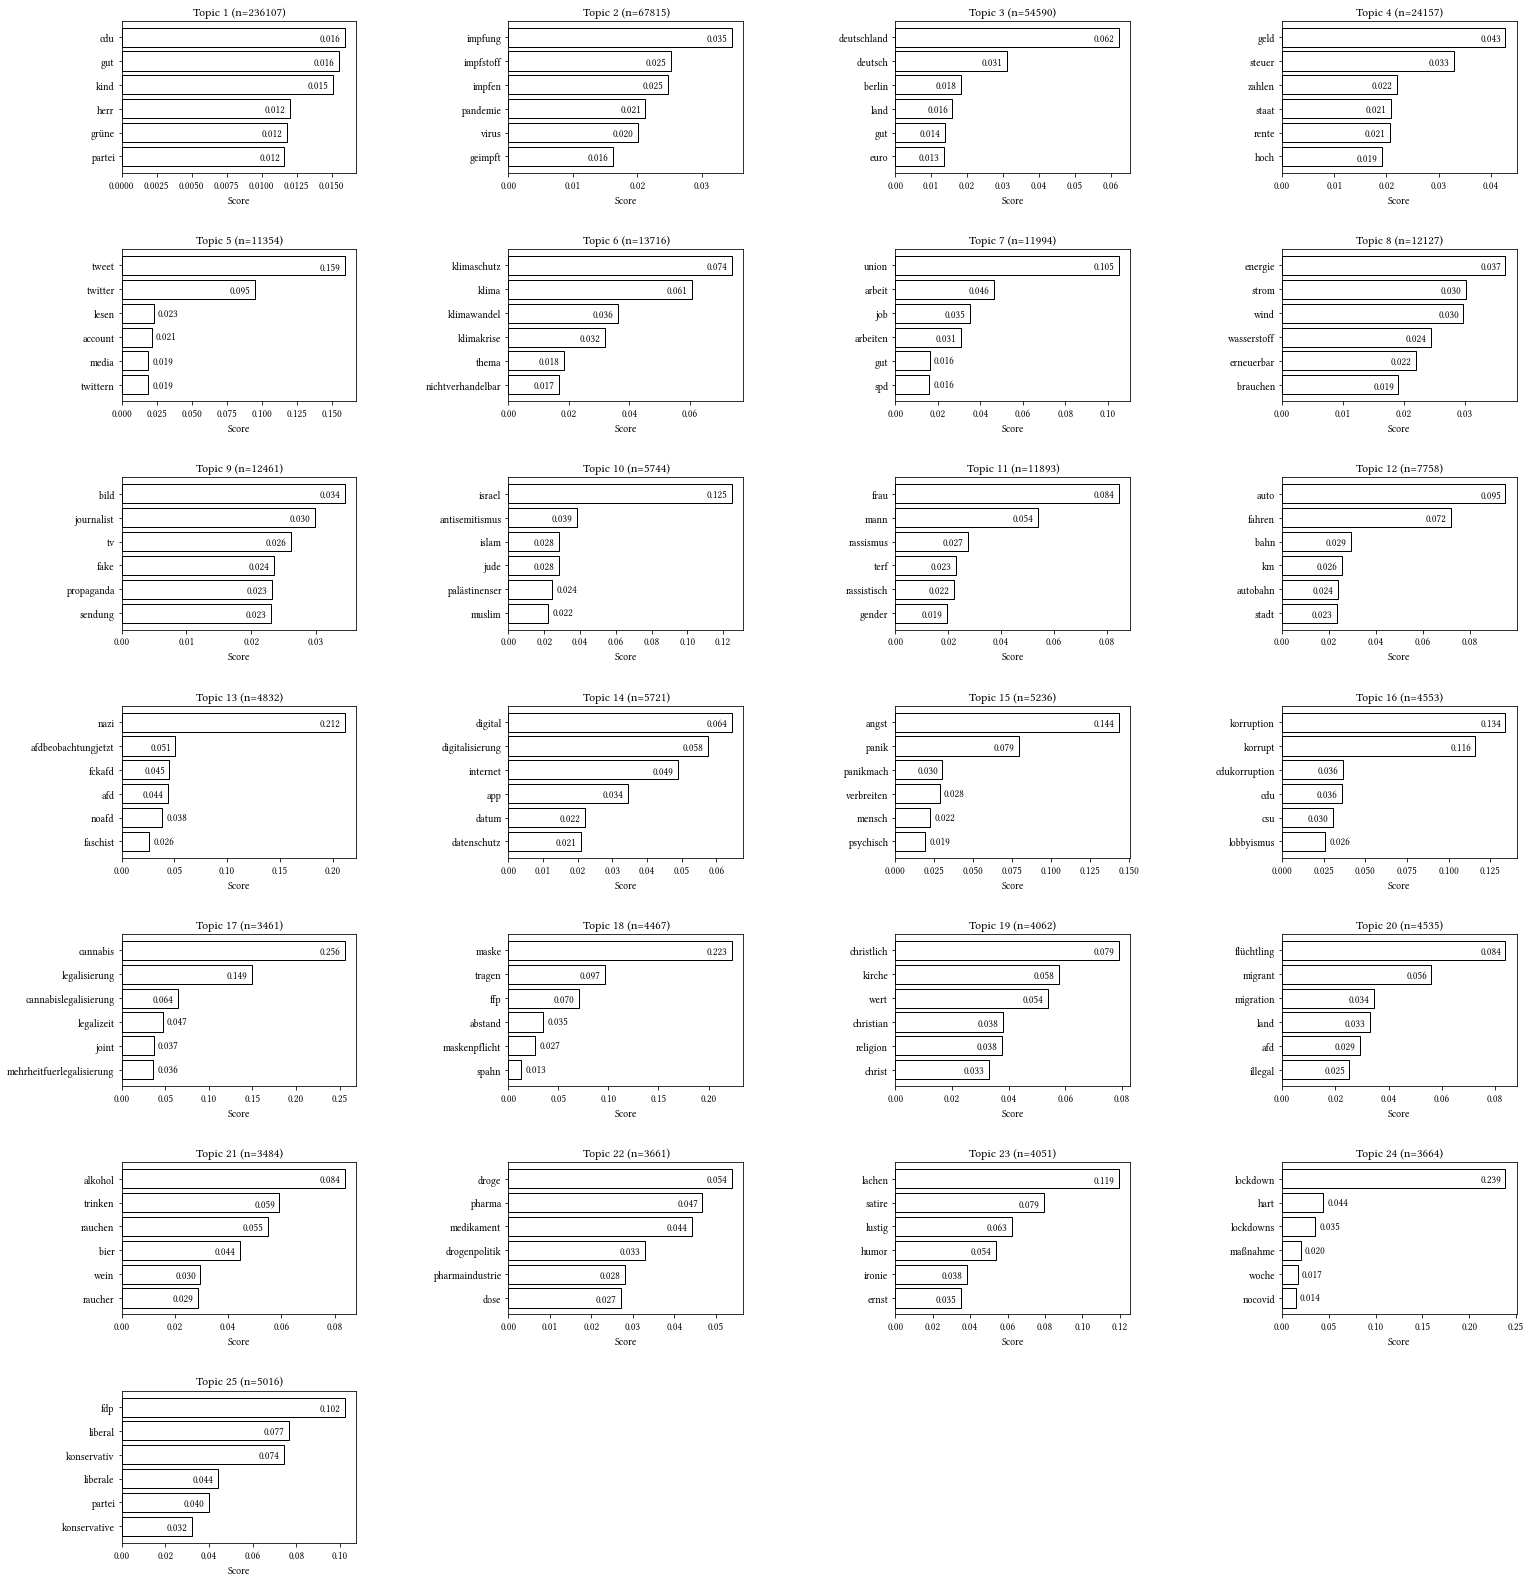

In [29]:
plot_topic_subplots(df_topics, n_topics, document_info["Topic"].value_counts(), filename="results/top5_topics")

A ward linkage function is used to perform the hierarchical clustering based on the cosine distance matrix between topic embeddings.

In [30]:
fig = model.visualize_hierarchy(width=2000, height=2000)
fig.write_html("results/hirachy.html")

Visualize a heatmap of the topic's similarity matrix. Based on the cosine similarity matrix between topic embeddings, a heatmap is created showing the similarity between topics.

In [31]:
fig = model.visualize_heatmap(width=2000, height=2000, top_n_topics=23)#(cleaned_text)
fig.write_html("results/heatmap.html")

### Topics over time

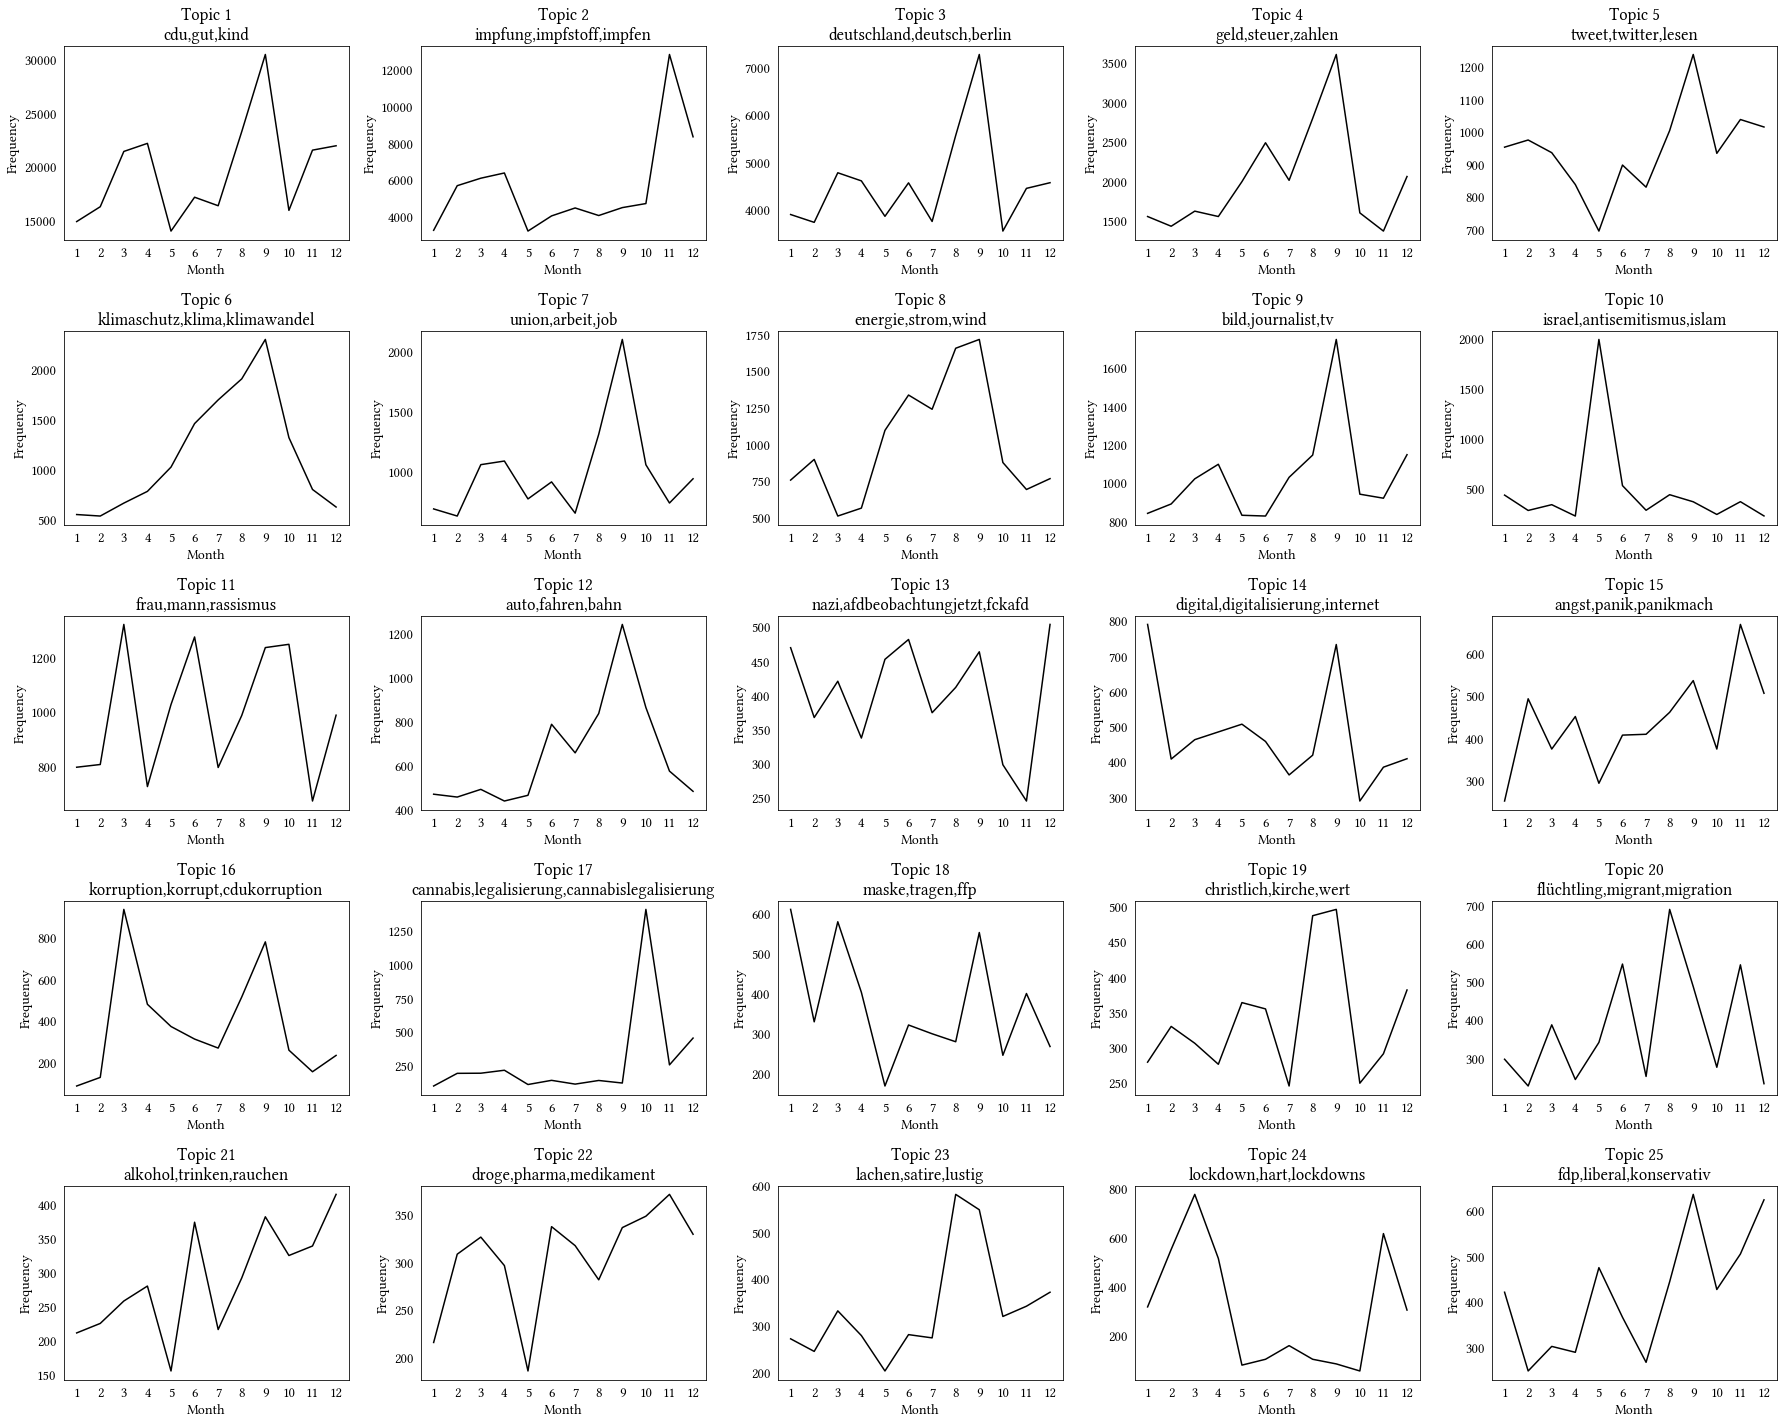

In [32]:
plot_timeseries_subplots(df_topics, n_topics, topics_over_time, filename="results/timeseries_topics")

#### Sentiment Over Time

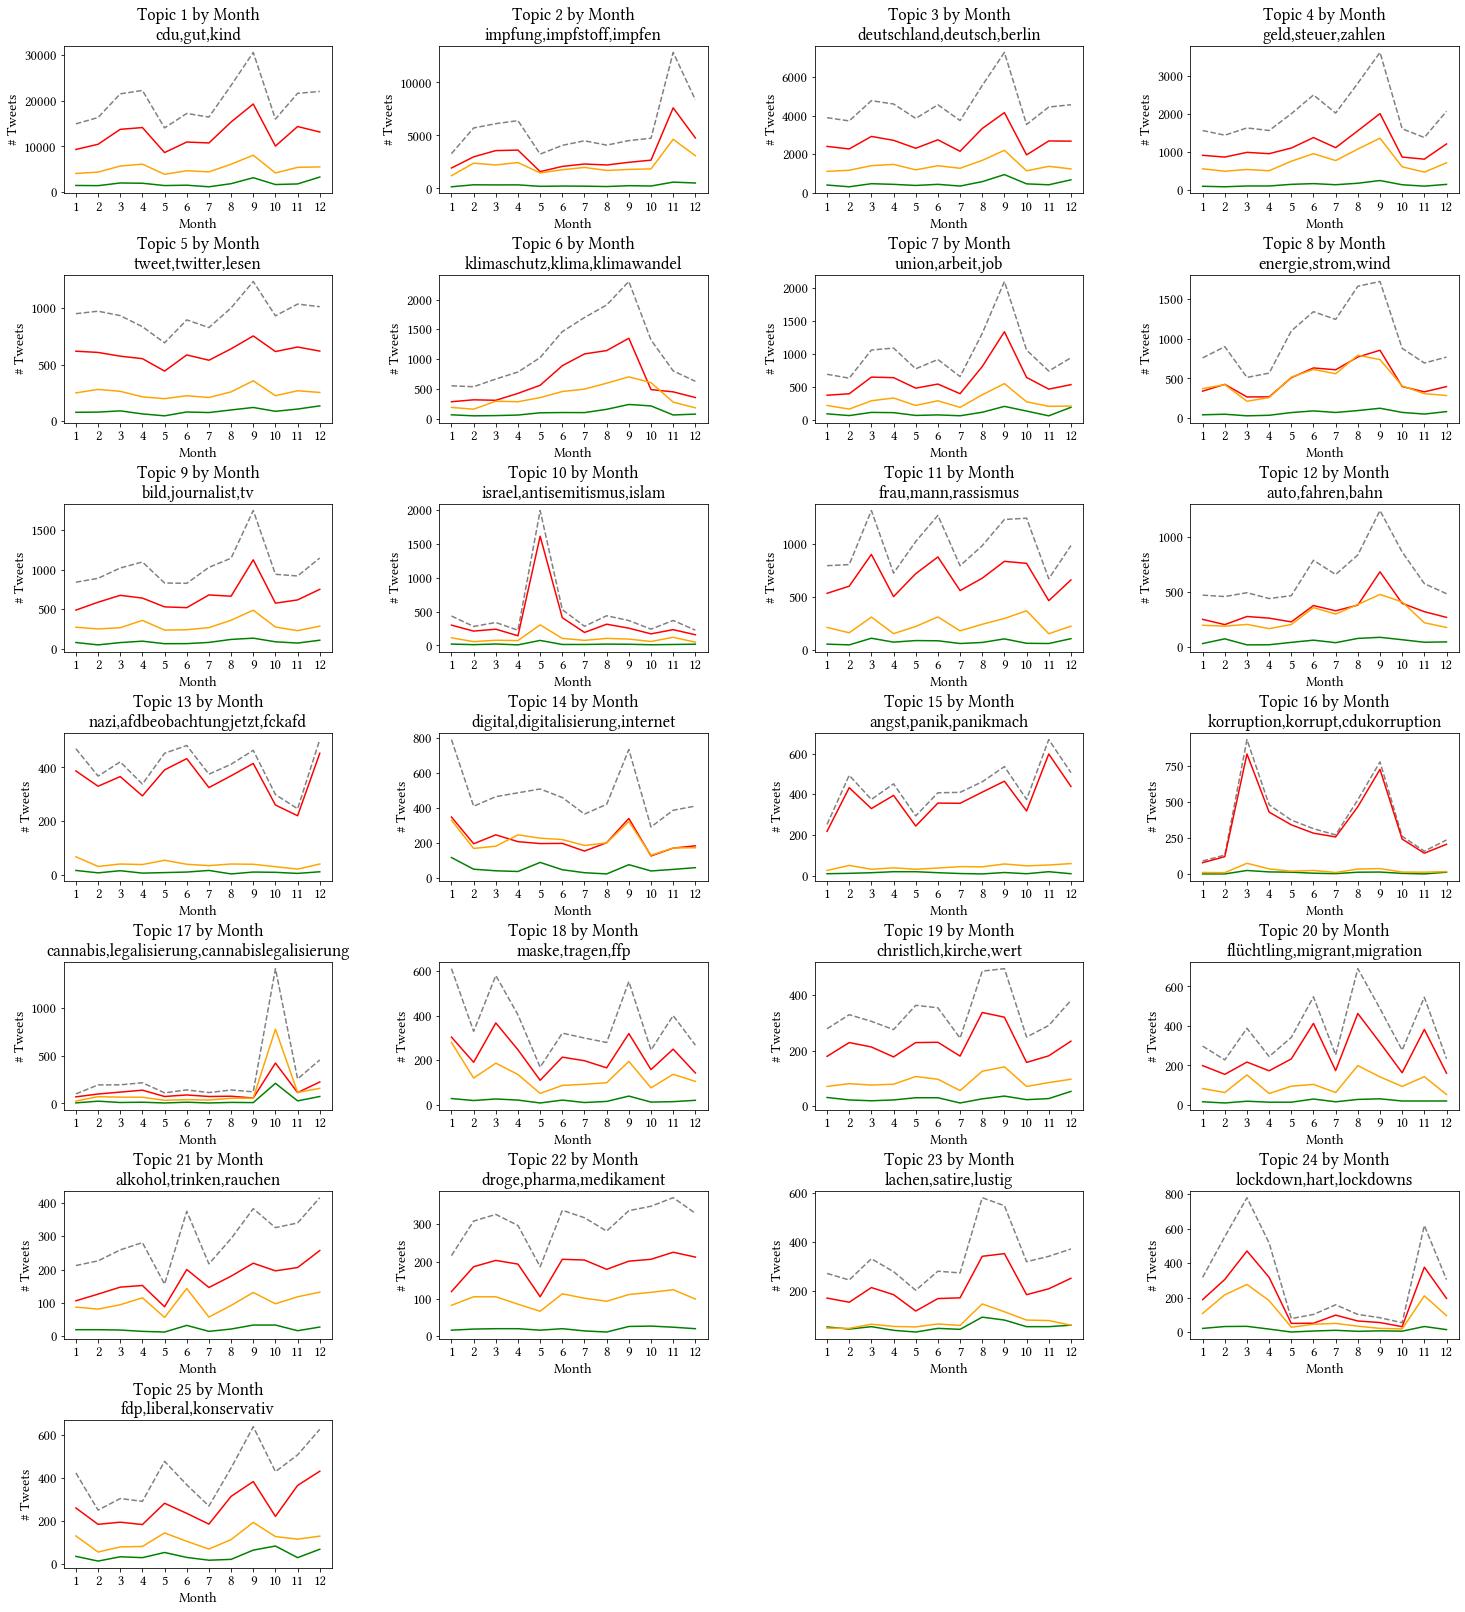

In [33]:
if 'sentiment' in df.columns:
     plot_timeseries_sentiment_subplots(df_topics, n_topics, document_info, topics_over_time, filename="results/timeseries_sentiment_subplots")

### Create Word Clouds

In [34]:
def svg_to_pdf(svg_filepath, pdf_filepath):
    drawing = svg2rlg(svg_filepath)
    renderPDF.drawToFile(drawing, pdf_filepath)

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wordcloud = WordCloud(background_color="white", max_words=1000, width=1000, height=700, font_path=FONT_PATH_WORDCLOUDS)
    wordcloud.generate_from_frequencies(text)
    
    base_path = f'wordclouds/wordcloud_topic_{topic}'
    
    # Save wordcloud as svg
    wordcloud_svg = wordcloud.to_svg(embed_font=True)
    svg_path = base_path + ".svg"
    f = open(svg_path, "w+")
    f.write(wordcloud_svg)
    f.close()

    # Save wordcloud as png
    png_path = base_path + ".png"
    wordcloud.to_file(png_path)
    
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

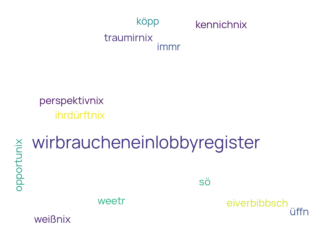

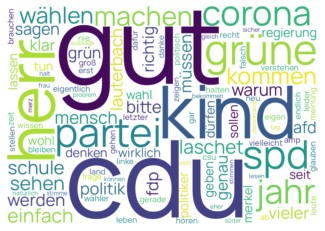

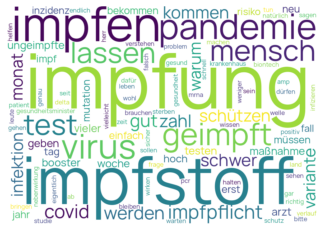

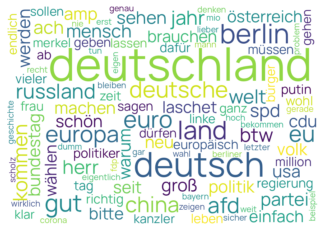

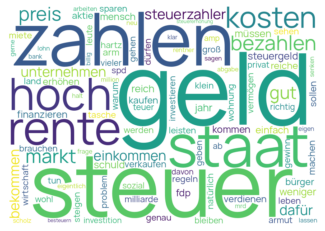

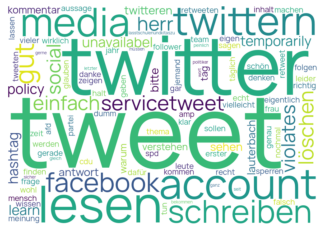

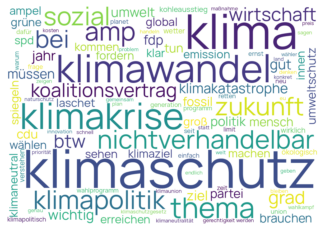

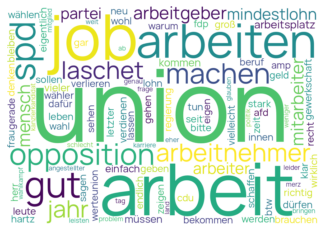

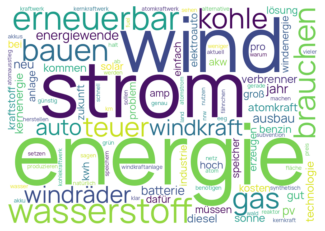

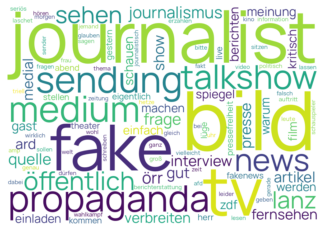

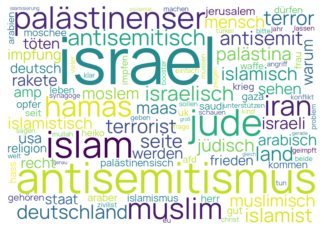

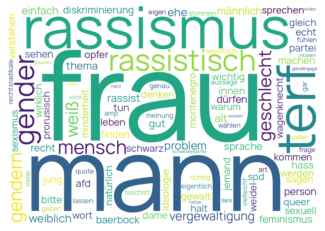

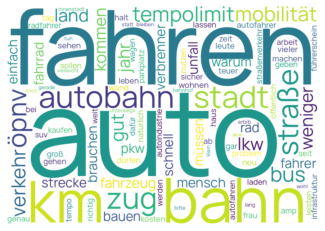

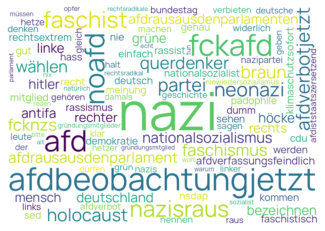

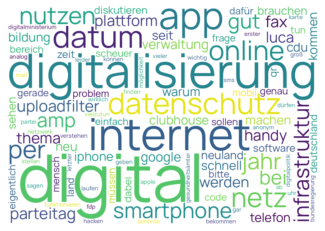

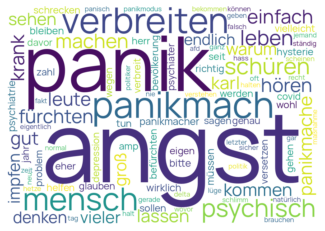

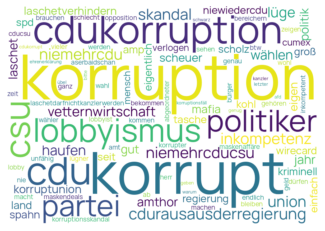

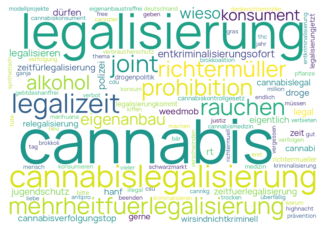

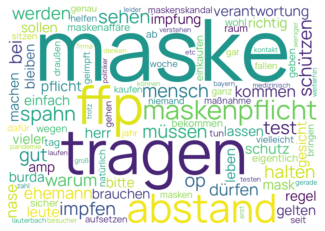

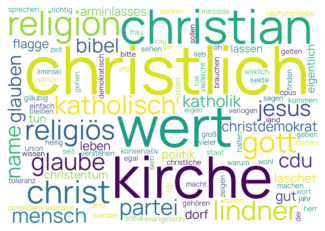

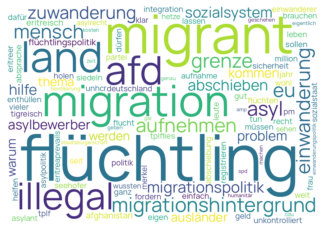

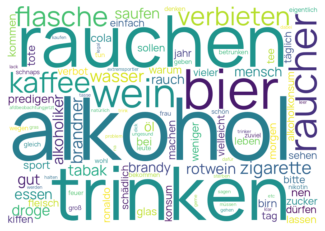

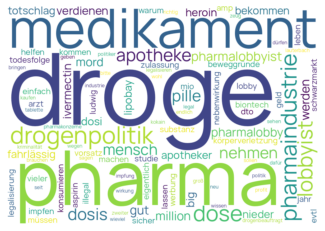

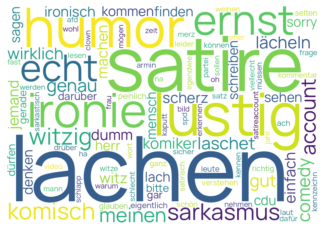

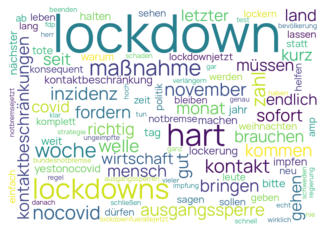

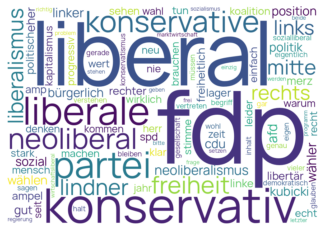

In [36]:
for topic in sorted(document_info["Topic"].unique()):
    create_wordcloud(model, topic=topic)

### Save Model

In [37]:
model.save(MODEL_OUTPUT_PATH)

/opt/conda/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [38]:
#model = BERTopic.load("politician_model")